In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import cv2
import glob
from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical

In [67]:
data_path = '../Data/cohn-kanade-images'
emotion_path = '../Data/Emotion'
facs_path = '../Data/FACS'
landmarks_path = '../Data/Landmarks'
crop_path = '../Data/Crop'

all_image_files = glob.glob(data_path+'/**/*.png', recursive=True)
all_emotion_files = glob.glob(emotion_path+'/**/*.txt', recursive=True)
all_facs_files = glob.glob(facs_path+'/**/*.txt', recursive=True)
all_landmarks_files = glob.glob(landmarks_path+'/**/*.txt', recursive=True)

In [3]:
# ONLY 327 of the 593 sequences have emotion sequences
# 0-7 (i.e. 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise)
all_emotions = {0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 
                4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}
all_image_files[:5], all_emotion_files[:5], all_facs_files[:5], all_landmarks_files[:5]

(['../Data/cohn-kanade-images/S005/001/S005_001_00000001.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000002.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000003.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000004.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000005.png'],
 ['../Data/Emotion/S005/001/S005_001_00000011_emotion.txt',
  '../Data/Emotion/S010/002/S010_002_00000014_emotion.txt',
  '../Data/Emotion/S010/004/S010_004_00000019_emotion.txt',
  '../Data/Emotion/S010/006/S010_006_00000015_emotion.txt',
  '../Data/Emotion/S011/001/S011_001_00000016_emotion.txt'],
 ['../Data/FACS/S005/001/S005_001_00000011_facs.txt',
  '../Data/FACS/S010/001/S010_001_00000014_facs.txt',
  '../Data/FACS/S010/002/S010_002_00000014_facs.txt',
  '../Data/FACS/S010/003/S010_003_00000018_facs.txt',
  '../Data/FACS/S010/004/S010_004_00000019_facs.txt'],
 ['../Data/Landmarks/S005/001/S005_001_00000001_landmarks.txt',
  '../Data/Landmarks/S005/001/S005_001_00000002_

In [76]:
pd.set_option('display.max_colwidth', -1)

crop_imsize = 200

def get_thumbnail(path):
    i = Image.open(path)
#     i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(im))

def crop_image_formatter(im):
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(Image.fromarray(np.uint8(im))))

face_det = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")

def detect_face(f):
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        gray = gray[y:y+h, x:x+w] #Cut the frame to size
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray
    return output

def print_metrics(y_test, y_pred):
    labels = dict(all_emotions)
    del labels[0]
    
    print(labels)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Classification Report: \n', classification_report(y_test, y_pred, 
                                                             target_names=[l for l in labels.values()]))
    
    conf_mat = confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(len(labels)), [l for l in labels.values()], rotation=90)
    _ = plt.yticks(range(len(labels)), [l for l in labels.values()])

# Creating Dataframe for images dataset

In [ ]:
df_images = pd.DataFrame.from_dict(image_dict).T
df_images.to_csv('ImageDict.csv', index=False)
df_images['im_emotion'] = df_images.emotion.map(lambda f: get_thumbnail(f))
df_images['im_neutral'] = df_images.neutral.map(lambda f: get_thumbnail(f))
df_images['im_emotion_crop'] = df_images.emotion.map(lambda f: detect_face(f))
df_images['im_neutral_crop'] = df_images.neutral.map(lambda f: detect_face(f))

# df_images.head()

In [77]:
df_images['im_emotion_crop'] = df_images.emotion.map(lambda f: detect_face(f))

,label,im_neutral,im_neutral_crop,im_emotion,im_emotion_crop
S005_001,3,,,,
S010_001,,,,,
S010_002,7,,,,
S010_003,,,,,
S010_004,1,,,,

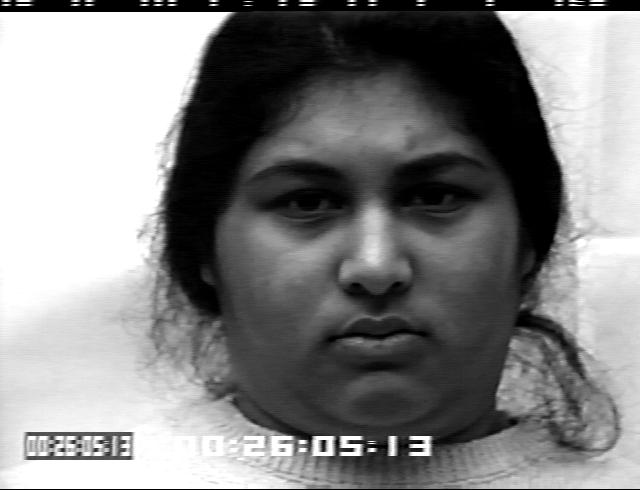
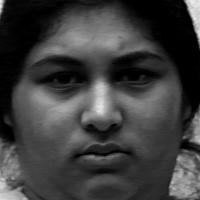
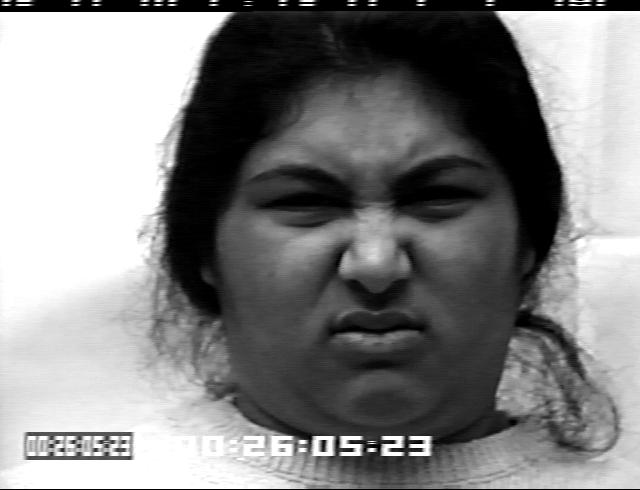
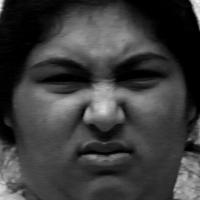
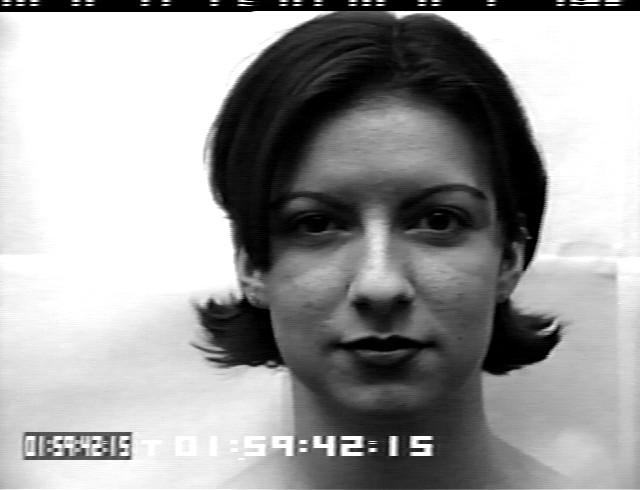
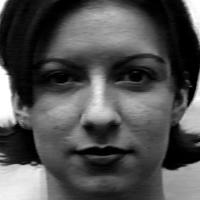
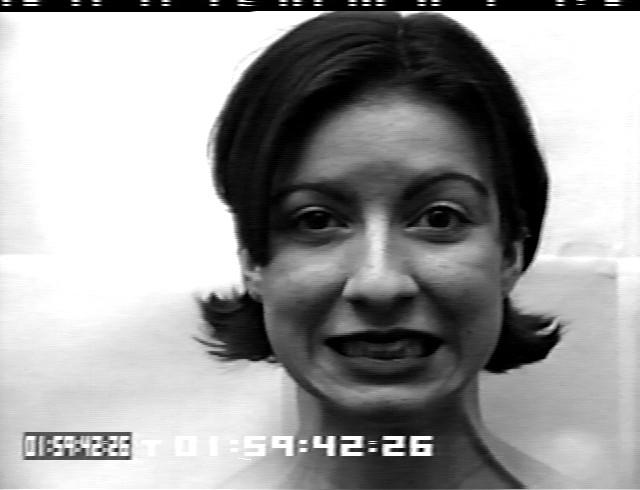
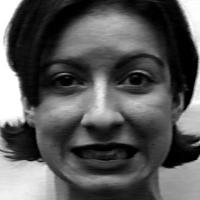
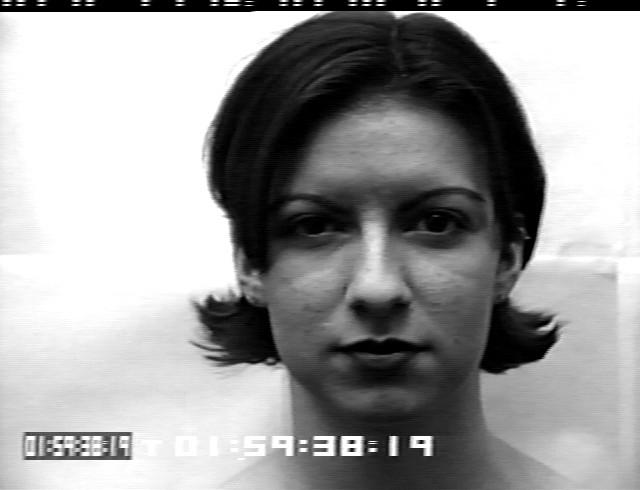
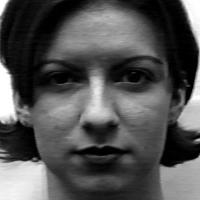
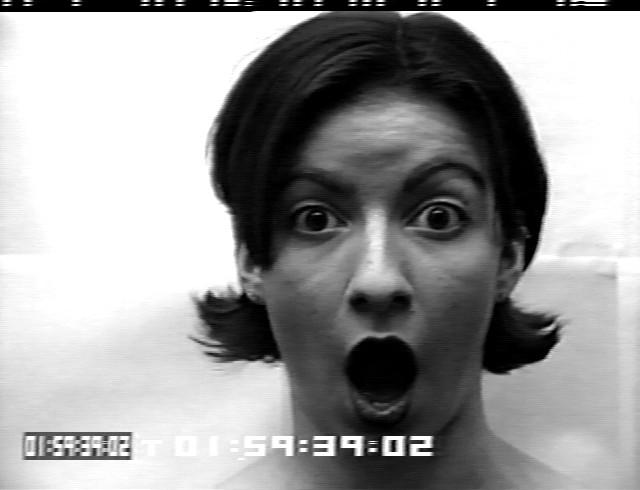
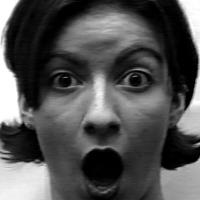
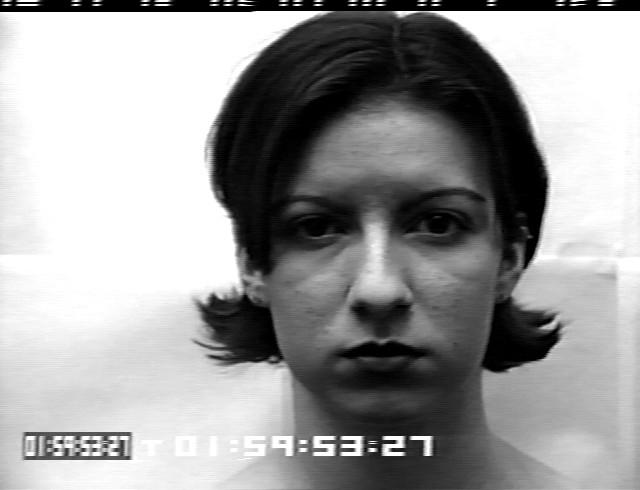
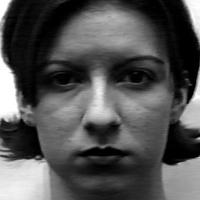
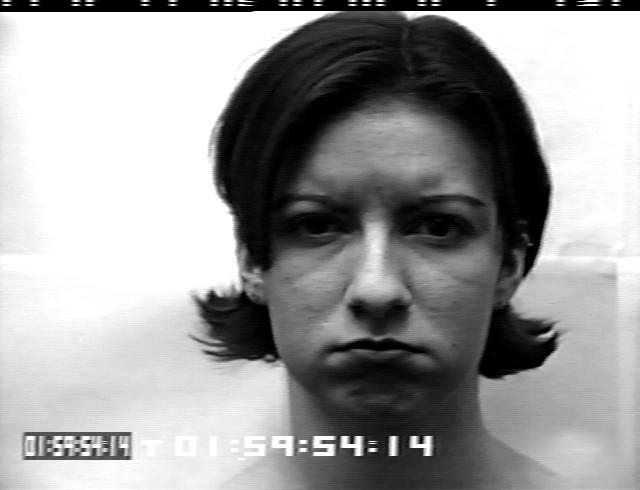
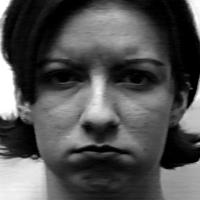
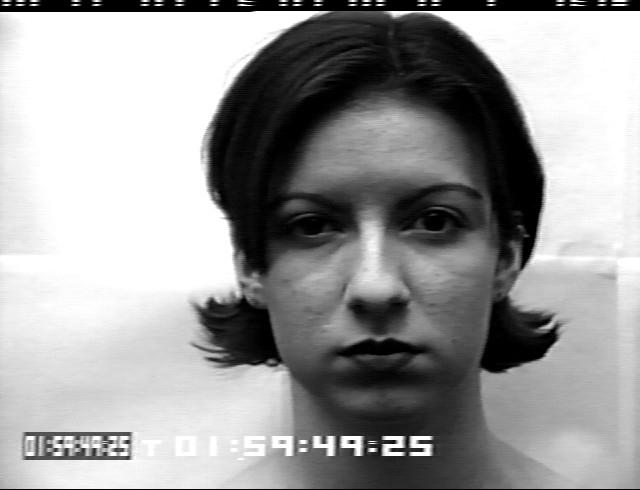
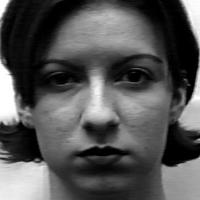
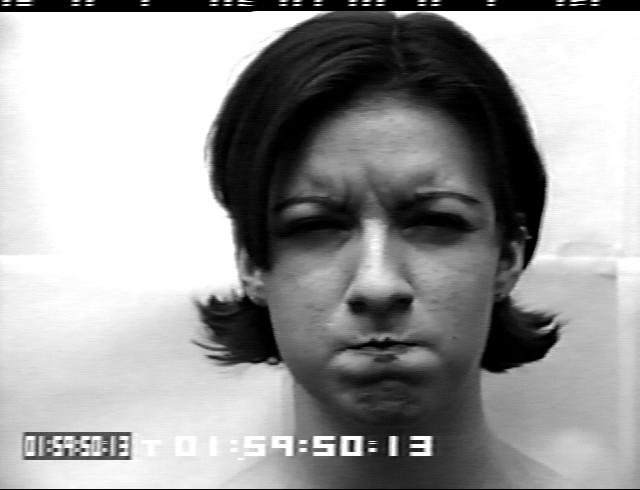
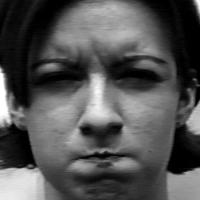

In [7]:
# displaying PIL.Image objects embedded in dataframe
HTML(df_images[['label', 'im_neutral', 'im_neutral_crop', 'im_emotion', 'im_emotion_crop']].head(5).to_html(formatters={'im_neutral': image_formatter, 
                                                                                                                         'im_emotion': image_formatter,
                                                                                                                         'im_neutral_crop': crop_image_formatter, 
                                                                                                                         'im_emotion_crop': crop_image_formatter}, escape=False))
# HTML(image_formatter(df_images[['im_neutral']].head(1)['im_neutral'][0]))
# df_images[['im_neutral']].head(1)['im_neutral'][0]

# Creating Emotion images and label as dataset
### Note: Neutral faces are not takin into account

In [8]:
df_cnn = df_images[df_images['label'] != ''][['im_emotion_crop', 'label']]

In [9]:
X, y = df_cnn['im_emotion_crop'], df_cnn['label']

In [10]:
X.shape, y.shape

((327,), (327,))

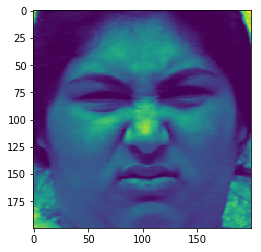

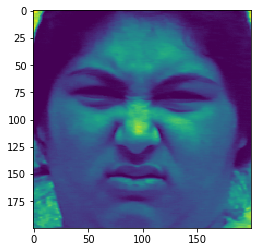

In [11]:
plt.imshow(X[0])
plt.show()
plt.imshow(np.fliplr(X[0]))

# Flipping images and combining to increase dataset

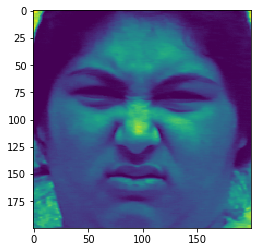

In [12]:
X_flip = X.apply(lambda x: np.fliplr(x))
plt.imshow(X_flip[0])

In [57]:
# X_total = X.reset_index(drop=True)
# y_total = to_categorical(y)
X_total = pd.concat([X.reset_index(drop=True), X_flip.reset_index(drop=True)], axis=0).reset_index(drop=True)
X_total = np.array([i for i in X_total])
X_total = X_total.reshape(X_total.shape[0], crop_imsize, crop_imsize, 1)
y_total = to_categorical(pd.concat([y, y], axis=0).reset_index(drop=True))

X_total.shape, y_total.shape

((654, 200, 200, 1), (654, 8))

In [58]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((523, 200, 200, 1), (131, 200, 200, 1), (523, 8), (131, 8))

# Creating keras CNN model

In [19]:
# #create model
# model = Sequential()

# #add model layers
# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(crop_imsize, crop_imsize, 1)))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(Conv2D(16, kernel_size=3, activation='relu'))
# model.add(Flatten())
# model.add(Dense(8, activation='softmax'))

# #compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(crop_imsize, crop_imsize, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=100)

Train on 523 samples, validate on 131 samples
Epoch 1/5
523/523 [==============================] - 1950s 4s/step - loss: 13.3497 - acc: 0.1568 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 2/5
523/523 [==============================] - 1847s 4s/step - loss: 13.8683 - acc: 0.1396 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 3/5
523/523 [==============================] - 1784s 3s/step - loss: 13.8683 - acc: 0.1396 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 4/5
523/523 [==============================] - 1752s 3s/step - loss: 13.8683 - acc: 0.1396 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 5/5


KeyboardInterrupt: 

In [61]:
y_pred = model.predict(X_test)

{1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}
Accuracy:  0.129770992366
Classification Report: 
               precision    recall  f1-score   support

       anger       0.13      1.00      0.23        17
    contempt       0.00      0.00      0.00         7
     disgust       0.00      0.00      0.00        28
        fear       0.00      0.00      0.00        13
       happy       0.00      0.00      0.00        22
     sadness       0.00      0.00      0.00        13
    surprise       0.00      0.00      0.00        31

   micro avg       0.13      0.13      0.13       131
   macro avg       0.02      0.14      0.03       131
weighted avg       0.02      0.13      0.03       131



/Users/apple/anaconda3/envs/BML/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


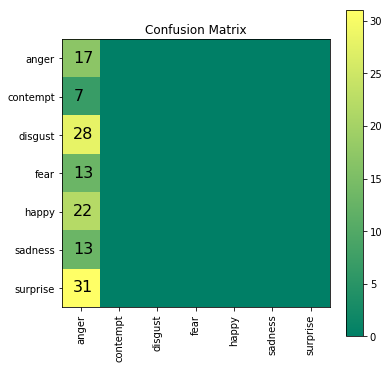

In [62]:
print_metrics(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [42]:
y_test.argmax(axis=1)

array([4, 7, 7, 7, 5, 6, 3, 3, 7, 7, 7, 7, 1, 7, 3, 4, 4, 7, 7, 4, 1, 6, 1,
       3, 1, 6, 3, 7, 2, 7, 5, 1, 5, 7, 7, 7, 1, 5, 2, 4, 5, 7, 5, 7, 7, 7,
       7, 5, 4, 4, 1, 5, 3, 2, 3, 6, 3, 1, 6, 7, 5, 1, 3, 6, 5, 3, 7, 3, 7,
       5, 3, 3, 5, 3, 3, 3, 1, 6, 1, 4, 3, 4, 1, 4, 5, 3, 6, 6, 5, 4, 3, 3,
       7, 3, 3, 7, 6, 5, 7, 4, 5, 1, 1, 7, 5, 1, 2, 2, 3, 2, 3, 3, 5, 6, 3,
       7, 7, 7, 4, 5, 3, 5, 5, 1, 7, 6, 2, 6, 1, 3, 5])

In [54]:
y_test[0]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.], dtype=float32)

In [78]:
ld, im = df_images.head(1)[['neutral_landmarks', 'neutral']].values[0]

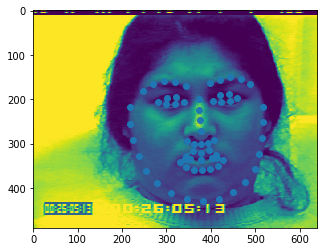

In [79]:
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

In [80]:
ld, im = df_images.head(1)[['emotion_landmarks', 'emotion']].values[0]

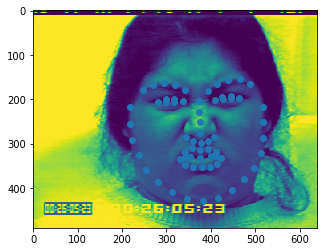

In [81]:
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

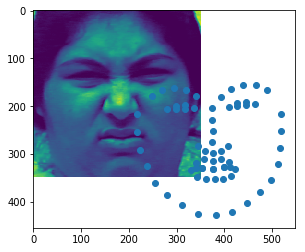

In [83]:
frame = cv2.imread(im) #Open image
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
face_det = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, w, h) in face:
    gray = gray[y:y+h, x:x+w] #Cut the frame to size
    
try:
    output = cv2.resize(gray, (350, 350))
except:
    output = gray
plt.imshow(Image.fromarray(np.uint8(output)))
plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

In [84]:
ld = np.array(ld)

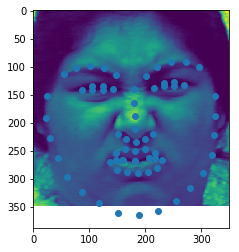

In [85]:
plt.imshow(Image.fromarray(np.uint8(output)))
plt.scatter(ld[:,0]-x, ld[:, 1]-y)